# Comparison of Random Forest and XGBoost Regression

In [ ]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!python -m pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 

In [4]:
# read in dataset
df = pd.read_excel('Data/globalterrorismdb_0522dist.xlsx')

## Preprocessing
##### Look at the data structure and identify repeated entries

In [75]:
# preprocessing
print(df.describe()) # describe the data to identify columns with missing data
print(df.head()) # visualise the dataset
print(df.columns.tolist) # get column names

## repeated values
print(df['eventid'].duplicated().sum()) # check for any repeated event ID numbers

            eventid          iyear         imonth           iday  \
count  2.097060e+05  209706.000000  209706.000000  209706.000000   
mean   2.004867e+11    2004.800993       6.455285      15.527930   
min    1.970000e+11    1970.000000       0.000000       0.000000   
25%    1.992080e+11    1992.000000       4.000000       8.000000   
50%    2.012010e+11    2012.000000       6.000000      15.000000   
75%    2.015123e+11    2015.000000       9.000000      23.000000   
max    2.020123e+11    2020.000000      12.000000      31.000000   
std    1.351933e+09      13.519321       3.387098       8.801104   

            extended                     resolution        country  \
count  209706.000000                           4861  209706.000000   
mean        0.051525  2006-12-14 11:22:40.581978880     130.291351   
min         0.000000            1970-03-08 00:00:00       4.000000   
25%         0.000000            1997-05-22 00:00:00      69.000000   
50%         0.000000            2013-

##### Select rows to analyse

In [5]:
## select rows after 1997 as not all variables were measured before this
df = df[df["iyear"]>1997]

## select rows that dont have NA value for nwound as that is the target variable
df = df[~df["nwound"].isna()]

##### Handle NA values

In [ ]:
df.describe() 

,eventid,iyear,imonth,iday,extended,resolution,country,region,latitude,longitude,...,ransomamt,ransomamtus,ransompaid,ransompaidus,hostkidoutcome,nreleased,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
count,1.303430e+05,130343.000000,130343.000000,130343.000000,130343.000000,3384,130343.000000,130343.000000,129457.000000,129457.000000,...,6.680000e+02,5.560000e+02,6.030000e+02,544.000000,8489.000000,8283.000000,130343.000000,130343.000000,130343.000000,130343.000000
mean,2.013285e+11,2013.218784,6.454140,15.599043,0.042051,2014-01-05 21:51:42.301713920,120.938424,7.914955,26.242281,50.910150,...,2.585992e+06,1.837380e+05,6.285185e+05,102.795956,4.127106,-15.346372,-4.947799,-4.849528,0.067307,-4.468364
min,1.998010e+11,1998.000000,1.000000,0.000000,0.000000,1993-11-08 00:00:00,4.000000,1.000000,-43.532941,-158.081142,...,-9.900000e+01,-9.900000e+01,-9.900000e+01,-99.000000,1.000000,-100.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,2.011060e+11,2011.000000,4.000000,8.000000,0.000000,2012-01-29 06:00:00,92.000000,6.000000,15.024380,38.350204,...,-9.900000e+01,0.000000e+00,-9.900000e+01,0.000000,2.000000,0.000000,-9.000000,-9.000000,0.000000,-9.000000
50%,2.014082e+11,2014.000000,6.000000,15.000000,0.000000,2014-12-09 00:00:00,95.000000,8.000000,32.422925,44.921904,...,7.991325e+03,0.000000e+00,0.000000e+00,0.000000,4.000000,0.000000,-9.000000,-9.000000,0.000000,-9.000000
75%,2.017021e+11,2017.000000,9.000000,23.000000,0.000000,2017-04-30 00:00:00,160.000000,10.000000,34.359073,70.736484,...,2.143390e+05,0.000000e+00,0.000000e+00,0.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,2.020123e+11,2020.000000,12.000000,31.000000,1.000000,2021-05-29 00:00:00,1004.000000,12.000000,74.633553,179.366667,...,2.000000e+08,2.000000e+07,2.750000e+08,48000.000000,7.000000,1201.000000,1.000000,1.000000,1.000000,1.000000
std,4.897885e+08,4.898438,3.382279,8.800148,0.200705,NaN,97.904161,2.402349,13.704486,38.021373,...,1.562966e+07,1.340904e+06,1.129283e+07,2101.677559,1.854061,49.762500,4.513486,4.630881,0.332297,4.693287


##### Identify relevant columns 

In [ ]:
# Get non-NA counts for each column that will be selected for features
sel_cols = df[["iyear","imonth","iday","extended","crit1","crit2","crit3","multiple",
"country","region_txt","vicinity","attacktype1_txt","success","suicide",
"weaptype1_txt","weaptype2_txt","targtype1_txt","nperps","nwound","property",
"nhostkid"]]
col_counts = sel_cols.count()
na_counts = col_counts[col_counts < 130343] # 130343 is the number of entries in columns with no na values

# print columns that are missing values, and how many entries they have
for col, count in na_counts.items():
    print(f"{col} = {count}")

weaptype2_txt = 10717
nperps = 118371
nkill = 129878
nhostkid = 8500


##### Remove NA values

In [6]:
# fill in NA values
## weaptype2 - replace with none, as it is likely there was no additional weapon used,
## leading to blank entries
df["weaptype2_txt"] = df["weaptype2_txt"].fillna("None")

## nperps - 11972 out of 130343 entries were NA, replace with an average of the 
## existing values
mean_nperps = df["nperps"].mean()
df["nperps"] = df["nperps"].fillna(mean_nperps)

## nhostkid - assumed blank/NA entries are due to no hostage situation so NA is 
## replaced with 0
df["nhostkid"] = df["nhostkid"].fillna(0)

##### Create dummy variables

In [7]:
## transformation
##create dummy variables
cols_to_encode = ['region_txt','attacktype1_txt','weaptype1_txt','weaptype2_txt','targtype1_txt'] 
prefixes = ['Region', 'AttackType', 'Weapon1', 'Weapon2', 'Target'] #new column names
df = pd.get_dummies(df, columns=cols_to_encode, prefix=prefixes, dtype=int)

In [8]:
##cleaning column names - removing spaces and symbols so they can be used as features
df.columns = (df.columns
    .str.replace(' & ', '_', regex=False)
    .str.replace(' ', '_', regex=False)
    .str.replace('/', '_', regex=False)
    .str.replace('-', '_', regex=False)
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
)


## First test of algorithms
### Feature Selection


In [ ]:
# Find and confirm column names for feature selection
# use ^ to find column names that begin with assigned names
## Attack type
df_attack = df.filter(regex='^AttackType')
print(df_attack.columns.tolist())

## Weapon 1
df_w1 = df.filter(regex='^Weapon1')
print(df_w1.columns.tolist())

## Weapon 2
df_w2 = df.filter(regex='^Weapon2')
print(df_w2.columns.tolist())

## Target
df_targ = df.filter(regex='^Target')
print(df_targ.columns.tolist())

## Region
df_reg = df.filter(regex='^Region')
print(df_reg.columns.tolist())

# rename column names that are too long
df = df.rename(columns = {'Weapon1_Vehicle_not_to_include_vehicle_borne_explosives,_i.e.,_car_or_truck_bombs':'Weapon1_Vehicle',
'Weapon2_Vehicle_not_to_include_vehicle_borne_explosives,_i.e.,_car_or_truck_bombs':'Weapon2_Vehicle'})

['AttackType_Armed_Assault', 'AttackType_Assassination', 'AttackType_Bombing_Explosion', 'AttackType_Facility_Infrastructure_Attack', 'AttackType_Hijacking', 'AttackType_Hostage_Taking_Barricade_Incident', 'AttackType_Hostage_Taking_Kidnapping', 'AttackType_Unarmed_Assault', 'AttackType_Unknown']
['Weapon1_Biological', 'Weapon1_Chemical', 'Weapon1_Explosives', 'Weapon1_Fake_Weapons', 'Weapon1_Firearms', 'Weapon1_Incendiary', 'Weapon1_Melee', 'Weapon1_Other', 'Weapon1_Radiological', 'Weapon1_Sabotage_Equipment', 'Weapon1_Unknown', 'Weapon1_Vehicle']
['Weapon2_Biological', 'Weapon2_Chemical', 'Weapon2_Explosives', 'Weapon2_Fake_Weapons', 'Weapon2_Firearms', 'Weapon2_Incendiary', 'Weapon2_Melee', 'Weapon2_None', 'Weapon2_Other', 'Weapon2_Sabotage_Equipment', 'Weapon2_Unknown', 'Weapon2_Vehicle']
['Target_Abortion_Related', 'Target_Airports_Aircraft', 'Target_Business', 'Target_Educational_Institution', 'Target_Food_or_Water_Supply', 'Target_Government_Diplomatic', 'Target_Government_Gener

In [ ]:
# feature selection
features = ["iyear","imonth","iday","extended","crit1","crit2","crit3",
"multiple","country","Region_North_America","Region_Central_America_Caribbean",
"Region_South_America","Region_East_Asia","Region_Southeast_Asia","Region_South_Asia",
"Region_Central_Asia","Region_Western_Europe","Region_Eastern_Europe",
"Region_Middle_East_North_Africa","Region_Sub_Saharan_Africa",
"Region_Australasia_Oceania","vicinity","AttackType_Assassination",
"AttackType_Hijacking","AttackType_Hostage_Taking_Kidnapping",
"AttackType_Hostage_Taking_Barricade_Incident","AttackType_Bombing_Explosion",
"AttackType_Armed_Assault","AttackType_Unarmed_Assault",
"AttackType_Facility_Infrastructure_Attack","AttackType_Unknown","success","suicide",
"Weapon1_Biological","Weapon1_Chemical","Weapon1_Radiological","Weapon1_Firearms",
"Weapon1_Explosives","Weapon1_Fake_Weapons","Weapon1_Incendiary","Weapon1_Melee","Weapon1_Sabotage_Equipment","Weapon1_Other","Weapon1_Unknown",
"Weapon2_Biological","Weapon2_Chemical","Weapon2_Explosives","Weapon2_Fake_Weapons",
"Weapon2_Firearms","Weapon2_Incendiary","Weapon2_Melee",
"Weapon2_Sabotage_Equipment","Weapon2_Other","Weapon2_Unknown","Target_Business",
"Target_Government_General","Target_Police","Target_Military","Target_Abortion_Related",
"Target_Airports_Aircraft","Target_Government_Diplomatic",
"Target_Educational_Institution","Target_Food_or_Water_Supply",
"Target_Journalists_Media","Target_Maritime","Target_NGO","Target_Other",
"Target_Private_Citizens_Property","Target_Religious_Figures_Institutions",
"Target_Telecommunication","Target_Terrorists_Non_State_Militia",
"Target_Tourists","Target_Transportation","Target_Unknown","Target_Utilities",
"Target_Violent_Political_Party","nperps","property","nhostkid"]
target = 'nwound' # outcome variable

print(len(features))

79


### Split the data

In [ ]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42) # 80/20 split


Training set: (104274, 197)
Testing set: (26069, 197)


### Random Forest regression

In [22]:
# random forest regression
from sklearn.ensemble import RandomForestRegressor # want regression as nwound is numeric

## set up the model
rfr = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=42)

## fit the model
rfr.fit(df_train[features], df_train[target])

## Make predictions
nwoundrf_pred = rfr.predict(df_test[features])

## Calculate RMSE
rmserf = np.sqrt(mean_squared_error(df_test[target], nwoundrf_pred))
print(f'RMSE is {rmserf}')

## Calculate R^2
r2rf = r2_score(df_test[target], nwoundrf_pred)
print(f'R-squared is {r2rf}')

## Calculate MAE
maerf = mean_absolute_error(df_test[target], nwoundrf_pred)
print(f'MAE is {maerf}')


RMSE is 47.702539570480134
R-squared is -1.4505477906573208
MAE is 4.080701400108474


### XGBoost regression

In [ ]:
# xgboost regression
from xgboost import XGBRegressor

## set up the model
xgbr = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)

## Fit the model
xgbr.fit(df_train[features], df_train[target])

## Make predictions
nwoundxg_pred = xgbr.predict(df_test[features])

## Calculate RMSE
rmsexg = np.sqrt(mean_squared_error(df_test[target], nwoundxg_pred))
print(f'RMSE is {rmsexg}')

## Calculate R^2
r2xg = r2_score(df_test[target], nwoundxg_pred)
print(f'R-squared is {r2xg}')

## Calculate MAE
maexg = mean_absolute_error(df_test[target], nwoundxg_pred)
print(f'MAE is {maexg}')

RMSE is 26.42433498042578
R^2 is 0.2480511350167678
MAE is 3.036327805482949


## Cross-validation
### Random Forest regression

In [ ]:
from sklearn.model_selection import cross_val_score

# Create a random forest regression model
cv_rfr = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=42) # criterion for regression

# Perform 5-fold cross-validation
## Define metrics
rfr_metrics = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']

## Calculate and print results
print("5-Fold Cross-Validation Results:")

for metric in rfr_metrics:
    cvrf_scores = cross_val_score(cv_rfr, df[features], df[target], cv=5, scoring=metric)
    print(f"\n{metric.upper()}:")
    print(f"  Individual fold scores: {cvrf_scores}")
    print(f"  Mean: {cvrf_scores.mean():.4f} (+/- {cvrf_scores.std():.4f})")

5-Fold Cross-Validation Results:

NEG_ROOT_MEAN_SQUARED_ERROR:
  Individual fold scores: [96.58005598  8.71757309  7.08016221 14.74510336  8.966685  ]
  Mean: 27.2179 (+/- 34.7781)

R2:
  Individual fold scores: [0.07887559 0.36417025 0.3567445  0.00633531 0.12871974]
  Mean: 0.1870 (+/- 0.1469)

NEG_MEAN_ABSOLUTE_ERROR:
  Individual fold scores: [5.67647463 2.80631199 2.53408915 2.71370675 2.42268323]
  Mean: 3.2307 (+/- 1.2302)


### XGBoost regression 

In [ ]:
# Create an XGBoost regression model
cv_xgb = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)

# Perform 5-fold cross-validation
## Define metrics
xgb_metrics = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']

## Calculate and print results
print("5-Fold Cross-Validation Results:")

for metric in xgb_metrics:
    cvxg_scores = cross_val_score(cv_xgb, df[features], df[target], cv=5, scoring=metric)
    print(f"\n{metric.upper()}:")
    print(f"  Individual fold scores: {cvxg_scores}")
    print(f"  Mean: {cvxg_scores.mean():.4f} (+/- {cvxg_scores.std():.4f})")


5-Fold Cross-Validation Results:

NEG_ROOT_MEAN_SQUARED_ERROR:
  Individual fold scores: [97.5364808   9.47144879  7.2056875  13.74200889  8.89898563]
  Mean: 27.3709 (+/- 35.1488)

R2:
  Individual fold scores: [0.06054161 0.24944507 0.33373355 0.13693269 0.14182658]
  Mean: 0.1845 (+/- 0.0959)

NEG_MEAN_ABSOLUTE_ERROR:
  Individual fold scores: [5.84617293 2.72421584 2.48146678 2.63504326 2.30979629]
  Mean: 3.1993 (+/- 1.3309)


### Select most important features

Region_North_America: 0.4079
nhostkid            : 0.1969
Target_Private_Citizens_Property: 0.1086
Weapon2_Incendiary  : 0.0691
Target_Government_General: 0.0649
iday                : 0.0291
imonth              : 0.0224
iyear               : 0.0180
country             : 0.0139


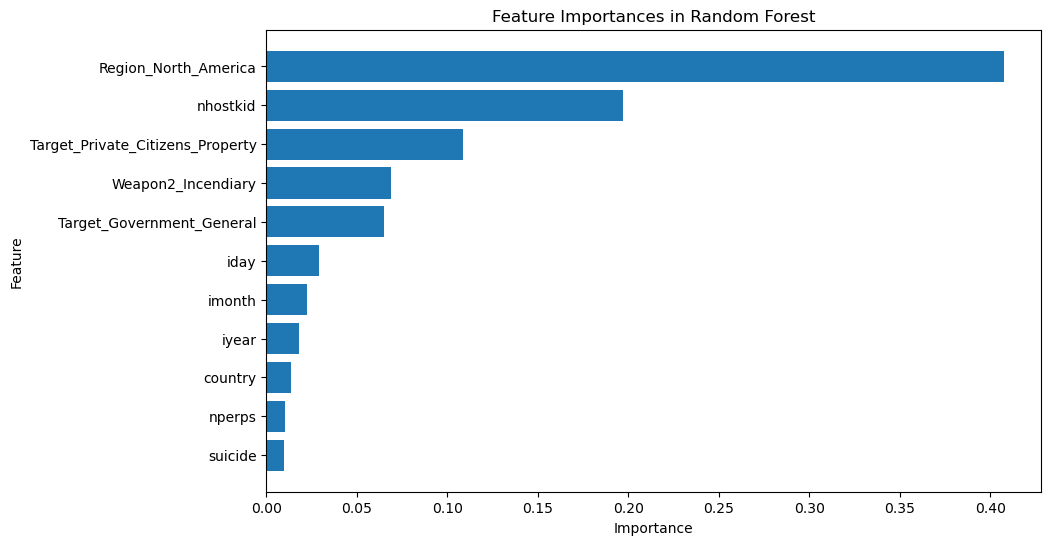

In [ ]:
# Use random forest results
# Get feature importances
rfr_importances = rfr.feature_importances_

# Sort by importance
rfr_sorted_idx = np.argsort(rfr_importances)[::-1]
rfr_sorted_features = [features[i] for i in rfr_sorted_idx]
rfr_sorted_importances = rfr_importances[rfr_sorted_idx]

# Select greater that 1/79
for name, score in zip(rfr_sorted_features, rfr_sorted_importances):
    if score > 0.0127:
        print(f"{name:<20}: {score:.4f}")


In [ ]:
## Select features from importances
features = ['Weapon1_Biological','Weapon1_Chemical','Weapon1_Explosives',
'Weapon1_Fake_Weapons','Weapon1_Firearms','Weapon1_Incendiary','Weapon1_Melee',
'Weapon1_Other','Weapon1_Radiological','Weapon1_Sabotage_Equipment','Weapon1_Unknown',
'Weapon1_Vehicle','Weapon2_Biological','Weapon2_Chemical','Weapon2_Explosives',
'Weapon2_Fake_Weapons','Weapon2_Firearms','Weapon2_Incendiary','Weapon2_Melee',
'Weapon2_None','Weapon2_Other','Weapon2_Sabotage_Equipment','Weapon2_Unknown',
'Weapon2_Vehicle','Target_Abortion_Related','Target_Airports_Aircraft',
'Target_Business','Target_Educational_Institution','Target_Food_or_Water_Supply', 
'Target_Government_Diplomatic','Target_Government_General','Target_Journalists_Media',
'Target_Maritime','Target_Military','Target_NGO','Target_Other','Target_Police', 
'Target_Private_Citizens_Property','Target_Religious_Figures_Institutions',
'Target_Telecommunication','Target_Terrorists_Non_State_Militia','Target_Tourists',
'Target_Transportation','Target_Unknown','Target_Utilities',
'Target_Violent_Political_Party','Region_Australasia_Oceania',
'Region_Central_America_Caribbean','Region_Central_Asia','Region_East_Asia', 
'Region_Eastern_Europe','Region_Middle_East_North_Africa','Region_North_America',
'Region_South_America','Region_South_Asia','Region_Southeast_Asia',
'Region_Sub_Saharan_Africa','Region_Western_Europe','nhostkid','iday','imonth','iyear']

print(len(features))

62


### Run on single split
##### Random Forest

In [136]:
# random forest regression
from sklearn.ensemble import RandomForestRegressor # want regression as nwound is numeric

## set up the model
rfr = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=42)

## fit the model
rfr.fit(df_train[features], df_train[target])

## Make predictions
nwoundrf_pred = rfr.predict(df_test[features])

## Calculate RMSE
rmserf = np.sqrt(mean_squared_error(df_test[target], nwoundrf_pred))
print(f'RMSE is {rmserf}')

## Calculate R^2
r2rf = r2_score(df_test[target], nwoundrf_pred)
print(f'R-squared is {r2rf}')

## Calculate MAE
maerf = mean_absolute_error(df_test[target], nwoundrf_pred)
print(f'MAE is {maerf}')

RMSE is 36.984120619929904
R-squared is -0.4730272100801003
MAE is 4.683959724883741


##### XGBoost

In [137]:
# xgboost regression
from xgboost import XGBRegressor

## set up the model
xgbr = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)

## Fit the model
xgbr.fit(df_train[features], df_train[target])

## Make predictions
nwoundxg_pred = xgbr.predict(df_test[features])

## Calculate RMSE
rmsexg = np.sqrt(mean_squared_error(df_test[target], nwoundxg_pred))
print(f'RMSE is {rmsexg}')

## Calculate R^2
r2xg = r2_score(df_test[target], nwoundxg_pred)
print(f'R-squared is {r2xg}')

## Calculate MAE
maexg = mean_absolute_error(df_test[target], nwoundxg_pred)
print(f'MAE is {maexg}')

RMSE is 30.045494800850836
R-squared is 0.027837428318405966
MAE is 4.330501146701293


## Reduce number of features manually

In [ ]:
# Select features Region and AttackType as they are likely to be the first bits of
# information available in the case of an attack
features = ["Region_North_America","Region_Central_America_Caribbean",
"Region_South_America","Region_East_Asia","Region_Southeast_Asia","Region_South_Asia",
"Region_Central_Asia","Region_Western_Europe","Region_Eastern_Europe",
"Region_Middle_East_North_Africa","Region_Sub_Saharan_Africa",
"Region_Australasia_Oceania","AttackType_Assassination",
"AttackType_Hijacking","AttackType_Hostage_Taking_Kidnapping",
"AttackType_Hostage_Taking_Barricade_Incident","AttackType_Bombing_Explosion",
"AttackType_Armed_Assault","AttackType_Unarmed_Assault",
"AttackType_Facility_Infrastructure_Attack","AttackType_Unknown"]
target = 'nwound'

##### Random Forest

In [11]:
# random forest regression
from sklearn.ensemble import RandomForestRegressor # want regression as nwound is numeric

## set up the model
rfr = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=42)

## fit the model
rfr.fit(df_train[features], df_train[target])

## Make predictions
nwoundrf_pred = rfr.predict(df_test[features])

## Calculate RMSE
rmserf = np.sqrt(mean_squared_error(df_test[target], nwoundrf_pred))
print(f'RMSE is {rmserf}')

## Calculate R^2
r2rf = r2_score(df_test[target], nwoundrf_pred)
print(f'R-squared is {r2rf}')

## Calculate MAE
maerf = mean_absolute_error(df_test[target], nwoundrf_pred)
print(f'MAE is {maerf}')

RMSE is 45.40178129444802
R-squared is -1.2198619147076717
MAE is 4.844686334935459


##### XGBoost

In [12]:
# xgboost regression
from xgboost import XGBRegressor

## set up the model
xgbr = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)

## Fit the model
xgbr.fit(df_train[features], df_train[target])

## Make predictions
nwoundxg_pred = xgbr.predict(df_test[features])

## Calculate RMSE
rmsexg = np.sqrt(mean_squared_error(df_test[target], nwoundxg_pred))
print(f'RMSE is {rmsexg}')

## Calculate R^2
r2xg = r2_score(df_test[target], nwoundxg_pred)
print(f'R-squared is {r2xg}')

## Calculate MAE
maexg = mean_absolute_error(df_test[target], nwoundxg_pred)
print(f'MAE is {maexg}')

RMSE is 44.10026661770127
R-squared is -1.0944143548416987
MAE is 4.832701214710539


## Hyperparameter Tuning
##### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

# define parameter list, balancing with computational efficiency
rf_param_distributions = {
    'n_estimators': [100],          # fixed
    'max_depth': [5, 8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Define random forest model
hp_rfr = RandomForestRegressor(random_state=42, n_jobs=-1)

# Create GridSearchCV object
rf_grid_search = GridSearchCV(
    estimator=hp_rfr,
    param_grid=rf_param_distributions,
    cv=2,                      # 2-fold CV
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit GridSearchCV on training data
rf_grid_search.fit(df_train[features], df_train[target])

# Print best parameters and CV score
print("GRID SEARCH RESULTS")
print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best CV R2 score: {rf_grid_search.best_score_:.4f}")

# Evaluate on test set
rf_y_pred = rf_grid_search.predict(df_test[features])

# Calculate scores 
rmse = np.sqrt(mean_squared_error(df_test[target], rf_y_pred))
mae = mean_absolute_error(df_test[target], rf_y_pred)
r2 = r2_score(df_test[target], rf_y_pred)

# Print scores
print("\nTest Set Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


Fitting 2 folds for each of 8 candidates, totalling 16 fits
GRID SEARCH RESULTS
Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best CV R2 score: -0.7320

Test Set Performance:
RMSE: 37.6455
MAE: 4.8529
R2: -0.5262


##### XGBoost

In [ ]:
# Define parameter grid for XGBoost
xgb_param_distributions = {
    'n_estimators': [100],          # fixed for speed
    'max_depth': [5, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define XGBoost model
hp_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Create GridSearchCV object
xgb_grid_search = GridSearchCV(
    estimator=hp_xgb,
    param_grid=xgb_param_distributions,
    cv=2,                      # 2-fold CV for large dataset
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit GridSearchCV on training data
xgb_grid_search.fit(df_train[features], df_train[target])

# Print best parameters and CV score
print("XGBOOST GRID SEARCH RESULTS")
print(f"Best parameters: {xgb_grid_search.best_params_}")
print(f"Best CV R2 score: {xgb_grid_search.best_score_:.4f}")

# Evaluate on test set
xgb_y_pred = xgb_grid_search.predict(df_test[features])

# Calculate scores
rmse = np.sqrt(mean_squared_error(df_test[target], xgb_y_pred))
mae = mean_absolute_error(df_test[target], xgb_y_pred)
r2 = r2_score(df_test[target], xgb_y_pred)

# Print scores
print("\nTest Set Performance (XGBoost):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

Fitting 2 folds for each of 16 candidates, totalling 32 fits
XGBOOST GRID SEARCH RESULTS
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV R2 score: -2.9655

Test Set Performance (XGBoost):
RMSE: 42.5614
MAE: 4.8364
R2: -0.9508
